In [1]:
import numpy as np
import pandas as pd
# %matplotlib qt
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d

from tqdm.notebook import tqdm

import modelbase
from modelbase.ode import Simulator

from scipy import integrate

plt.style.use("./notebook.mplstyle")
print(modelbase.__version__)

1.3.5


In [2]:
%%capture
cd ..

In [3]:
from models import get_model


m = get_model()

par_orig = m.get_parameters()

def get_new_y0(s):
    return dict(s.get_results_df().iloc[-1])

In [4]:
y0 = {
    "PQ": 11.027139850905353,
    "PC": 1.8895071932002812,
    "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,
    "NADPH": 0.4882103700673736,
    "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,
    "Psbs": 0.9607146039898598,
    "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,
    "BPGA": 0.0005355311557548053,
    "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,
    "FBP": 0.006126990841013743,
    "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,
    "G1P": 0.041575582577936025,
    "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,
    "E4P": 0.00732079113061801,
    "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,
    "RUBP": 0.13153657267999222,
    "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,
    "ASC": 9.999994138785292,
    "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,
    "GSH": 9.999999991725186,
    "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
}

y0_1000 = {
    "PQ": 1.507789886702025,
    "PC": 3.953187158958296,
    "Fd": 1.1279937081043432,
    "ATP": 2.400518163834891,
    "NADPH": 0.7833511016622213,
    "H": 11.834462552026038,
    "LHC": 0.3057293990674661,
    "Psbs": 0.5000000000384304,
    "Vx": 0.09090909091242916,
    "PGA": 0.04883787233687633,
    "BPGA": 0.0002431280086079331,
    "GAP": 0.019630698252342628,
    "DHAP": 0.43187533951527735,
    "FBP": 0.06019389866167178,
    "F6P": 2.6879366796632724,
    "G6P": 6.1822543628081625,
    "G1P": 0.35857075303234864,
    "SBP": 1.1860893478540198,
    "S7P": 0.044187268369558365,
    "E4P": 0.2112592088267863,
    "X5P": 0.02098062469006194,
    "R5P": 0.035142545427180046,
    "RUBP": 0.37432944394392,
    "RU5P": 0.0140570180127999,
    "MDA": 0.009653405870311431,
    "ASC": 9.959784342928879,
    "H2O2": 0.0008037536118780133,
    "DHA": 0.030562251200941273,
    "GSH": 9.976204054020393,
    "GSSG": 0.011897972989793133,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
}

In [5]:
def get_minmax(s,T_END):
    c = s.get_full_results_df()
    v = s.get_fluxes_df()
    
    cmin = c.loc[T_END*0.75:,:].min()
    cmax = c.loc[T_END*0.75:,:].max()
    vmin = v.loc[T_END*0.75:,:].min()
    vmax = v.loc[T_END*0.75:,:].max()
    
    return cmin, cmax, vmin, vmax

def get_avg(s, T_END):
    c = s.get_full_results_df()
    v = s.get_fluxes_df()
    
    vavg=pd.Series(
        integrate.trapezoid(
            v.loc[T_END*0.75:,:],x=v.loc[T_END*0.75:,:].index,axis=0
        ) / (T_END-v.loc[T_END*0.75:,:].index.min()),
        index=v.columns)

    cavg=pd.Series(
        integrate.trapezoid(
            c.loc[T_END*0.75:,:],x=c.loc[T_END*0.75:,:].index,axis=0
        ) / (T_END-v.loc[T_END*0.75:,:].index.min()),
        index=c.columns)

    return cavg.T, vavg.T

In [108]:
s=Simulator(m)
s.initialise(y0)
t,y=s.simulate(2000)

In [162]:
def par_scan_osc_2d(s, par_name1, par_values1, par_name2, par_values2, y0_loop, T_END = 100000):
    cmin = {}
    cmax = {}
    vmin = {}
    vmax = {}
    cavg = {}
    vavg = {}
    
    y0_outerloop = y0_loop
    
    for i, x1 in tqdm(enumerate(par_values1), total=len(par_values1)):
        
        cmin[x1]={}
        cmax[x1]={}
        vmin[x1]={}
        vmax[x1]={}
        cavg[x1]={}
        vavg[x1]={}
        
        s.update_parameter(par_name1, x1)
        
        for j, x2 in tqdm(enumerate(par_values2), total=len(par_values2)):
            
            if j == 0:
                s.initialise(y0_outerloop)
            else:
                s.initialise(y0_loop)
            
            s.update_parameter(par_name2, x2)
            
            try:
                t, y = s.simulate(T_END)
                #concentrations[x] = dict(s.get_full_results_df().iloc[-1])
                #fluxes[x] = dict(s.get_fluxes_df().iloc[-1])
                cmin[x1][x2], cmax[x1][x2], vmin[x1][x2], vmax[x1][x2] = get_minmax(s,T_END)
                cavg[x1][x2], vavg[x1][x2] = get_avg(s,T_END)
                y0_loop = get_new_y0(s)
                
                if j == 0:
                    y0_outerloop = y0_loop
                    
                
            except:
                all_compounds = s.model.get_all_compounds()
                rate_names = s.model.get_rate_names()
                cmin[x1][x2] = pd.Series(dict(
                    zip(all_compounds, np.full(len(all_compounds), np.nan))
                ))
                cmax[x1][x2] = pd.Series(dict(
                    zip(all_compounds, np.full(len(all_compounds), np.nan))
                ))
                cavg[x1][x2] = pd.Series(dict(
                    zip(all_compounds, np.full(len(all_compounds), np.nan))
                ))
                vmin[x1][x2] = pd.Series(dict(zip(rate_names, np.full(len(rate_names), np.nan))))
                vmax[x1][x2] = pd.Series(dict(zip(rate_names, np.full(len(rate_names), np.nan))))
                vavg[x1][x2] = pd.Series(dict(zip(rate_names, np.full(len(rate_names), np.nan))))

    multidfs = []
    
    mesh=np.meshgrid(par_values2,par_values1)
    colinds=[x.flatten() for x in mesh]

    for sol in (cmin, cmax, vmin, vmax, cavg, vavg):
        dfs=[]
        for i in sol.keys():
            for j in sol[i].keys():
                dfs.append(sol[i][j])
        df3 = pd.DataFrame(data=np.array(dfs).T, index=dfs[0].index, columns=pd.MultiIndex.from_tuples(zip(*colinds)))
        multidfs.append(df3)
    
    return multidfs
        

        
#    return cmin, cmax, vmin, vmax, cavg, vavg

#    return pd.DataFrame(cmin).T, pd.DataFrame(cmax).T, pd.DataFrame(vmin).T, pd.DataFrame(vmax).T, pd.DataFrame(cavg).T, pd.DataFrame(vavg).T
#    return pd.DataFrame(cmin).T, pd.DataFrame(cmax).T, pd.DataFrame(vmin).T, pd.DataFrame(vmax).T

## light harvesting efficiency as function of RuBisCO and SBPase in low light (PPFD=100)

In [112]:
NUM_SCANS = 20
MIN_LOG_F = -3.2
MAX_LOG_F = 3.2
xscale = np.linspace(MIN_LOG_F, MAX_LOG_F, NUM_SCANS)
v1_vals = par_orig["V1_base"]*(2**xscale)
v9_vals = par_orig["V9_base"]*(2**xscale)

In [123]:
mdfs = par_scan_osc_2d(s,"V1_base",v1_vals,"V9_base",v9_vals,y0,T_END=2000)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

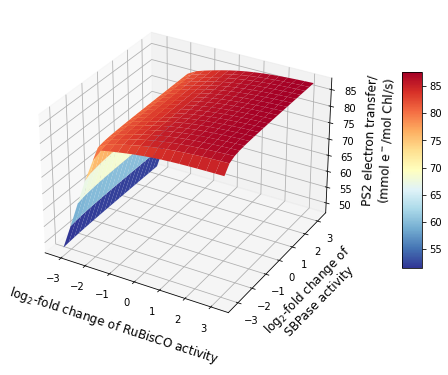

In [258]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')
X,Y=np.meshgrid(xscale,xscale)
(cmin, cmax, vmin, vmax, cavg, vavg) = mdfs
surf = ax.plot_surface(X,Y,2*np.array(vavg.loc["vPS2"]).reshape(20,20),cmap='RdYlBu_r', edgecolor='none')
#ax.plot_surface(X,Y,np.array(cavg.loc["ATP_norm"]).reshape(20,20),cmap='RdYlBu_r', edgecolor='none')

ax.set_xlabel("log$_2$-fold change of RuBisCO activity",labelpad=10)
ax.set_ylabel("log$_2$-fold change of\nSBPase activity",labelpad=10)
#ax.set_zlabel("PS2 electron transfer/(mmol e$^-$/mol Chl/s)")
ax.set_zlabel("PS2 electron transfer/\n(mmol e$^-$/mol Chl/s)",labelpad=10)

fig.colorbar(surf,shrink=0.6,aspect=10,ax=ax, pad=0.1)

## light harvesting efficiency as function of RuBisCO and SBPase in high light (PPFD=1000)

In [218]:
m=get_model()
s=Simulator(m)
s.initialise(y0)

s.update_parameter('pfd',1000)
mdfs1000 = par_scan_osc_2d(s,"V1_base",v1_vals,"V9_base",v9_vals,y0,T_END=2000)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [231]:
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

In [290]:
def get_interpolated_values(df,ind):
    y=np.array(df.loc[ind])
    nans, x = nan_helper(y)
    y[nans] = np.interp(x(nans), x(~nans), y[~nans])
    return y

In [235]:
ps2=np.array(vavg.loc["vPS2"])
nans, x= nan_helper(ps2)
ps2[nans]= np.interp(x(nans), x(~nans), ps2[~nans])

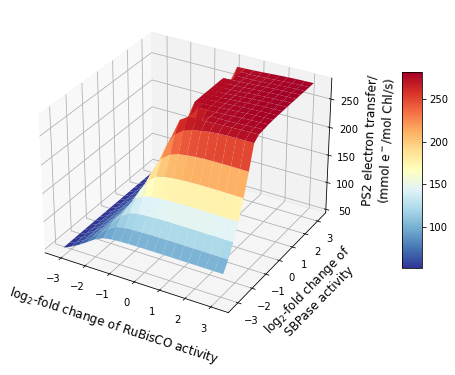

In [260]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')
X,Y=np.meshgrid(xscale,xscale)
(cmin, cmax, vmin, vmax, cavg, vavg) = mdfs1000
surf=ax.plot_surface(X,Y,ps2.reshape(20,20),cmap='RdYlBu_r', edgecolor='none')
#ax.plot_surface(X,Y,np.array(cavg.loc["ATP_norm"]).reshape(20,20),cmap='RdYlBu_r', edgecolor='none')

ax.set_xlabel("log$_2$-fold change of RuBisCO activity",labelpad=10)
ax.set_ylabel("log$_2$-fold change of\nSBPase activity",labelpad=10)
#ax.set_zlabel("PS2 electron transfer/(mmol e$^-$/mol Chl/s)")
ax.set_zlabel("PS2 electron transfer/\n(mmol e$^-$/mol Chl/s)",labelpad=10)

fig.colorbar(surf,shrink=0.6,aspect=10,ax=ax, pad=0.1)

In [268]:
vavg.index

Index(['vPS2', 'vPS1', 'vPTOX', 'vNDH', 'vB6f', 'vCyc', 'vFNR', 'vLeak',
       'vSt12', 'vSt21', 'vATPsynthase', 'vDeepox', 'vEpox', 'vLhcprotonation',
       'vLhcdeprotonation', 'vRuBisCO', 'vPGA_kinase', 'vBPGA_dehydrogenase',
       'vTPI', 'vAldolase', 'vFBPase', 'vF6P_Transketolase', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'vG6P_isomerase', 'vPhosphoglucomutase', 'vpga',
       'vgap', 'vdhap', 'vStarch', 'vFdred', 'vAscorbate', 'vMDAreduct',
       'vMehler', 'vGR', 'vDHAR', 'v3ASC', 'vEX_ATP', 'vEX_NADPH',
       'vFdTrReductase', 'vE_activation', 'vE_inactivation'],
      dtype='object')

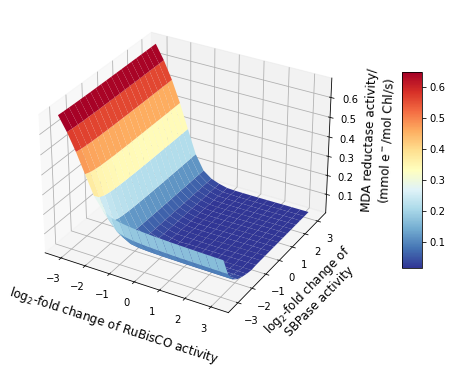

In [283]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')
X,Y=np.meshgrid(xscale,xscale)
(cmin, cmax, vmin, vmax, cavg, vavg) = mdfs1000
mdar=np.array(vavg.loc["vMDAreduct"])
nans, x= nan_helper(mdar)
mdar[nans]= np.interp(x(nans), x(~nans), mdar[~nans])
surf=ax.plot_surface(X,Y,2*mdar.reshape(20,20),cmap='RdYlBu_r', edgecolor='none')
#ax.plot_surface(X,Y,np.array(cavg.loc["ATP_norm"]).reshape(20,20),cmap='RdYlBu_r', edgecolor='none')

ax.set_xlabel("log$_2$-fold change of RuBisCO activity",labelpad=10)
ax.set_ylabel("log$_2$-fold change of\nSBPase activity",labelpad=10)
ax.set_zlabel("MDA reductase activity/\n(mmol e$^-$/mol Chl/s)",labelpad=10)

fig.colorbar(surf,shrink=0.6,aspect=10,pad=0.1)


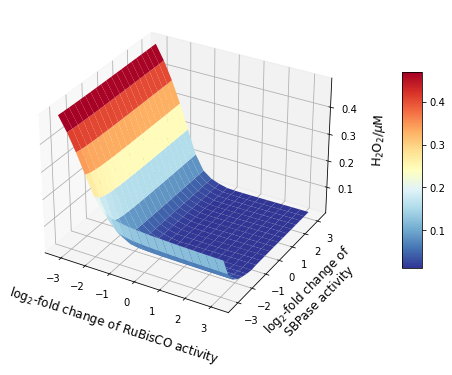

In [287]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')
X,Y=np.meshgrid(xscale,xscale)
(cmin, cmax, vmin, vmax, cavg, vavg) = mdfs1000
h2o2=np.array(cavg.loc["H2O2"])
nans, x= nan_helper(h2o2)
h2o2[nans]= np.interp(x(nans), x(~nans), h2o2[~nans])
surf=ax.plot_surface(X,Y,1000*h2o2.reshape(20,20),cmap='RdYlBu_r', edgecolor='none')
#ax.plot_surface(X,Y,np.array(cavg.loc["ATP_norm"]).reshape(20,20),cmap='RdYlBu_r', edgecolor='none')

ax.set_xlabel("log$_2$-fold change of RuBisCO activity",labelpad=10)
ax.set_ylabel("log$_2$-fold change of\nSBPase activity",labelpad=10)
ax.set_zlabel("H$_2$O$_2$/$\mu$M",labelpad=10)

fig.colorbar(surf,shrink=0.6,aspect=10,pad=0.1)


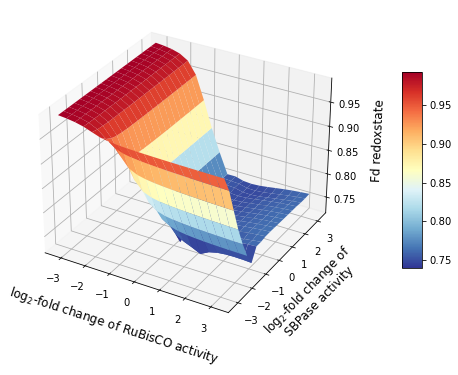

In [292]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')
X,Y=np.meshgrid(xscale,xscale)
(cmin, cmax, vmin, vmax, cavg, vavg) = mdfs1000

#atp=np.array(cavg.loc["ATP_norm"])
#nans, x= nan_helper(atp)
#atp[nans]= np.interp(x(nans), x(~nans), atp[~nans])
disp = get_interpolated_values(cavg,"Fd_redoxstate")

surf=ax.plot_surface(X,Y,disp.reshape(20,20),cmap='RdYlBu_r', edgecolor='none')

ax.set_xlabel("log$_2$-fold change of RuBisCO activity",labelpad=10)
ax.set_ylabel("log$_2$-fold change of\nSBPase activity",labelpad=10)
ax.set_zlabel("Fd redoxstate",labelpad=10)

fig.colorbar(surf,shrink=0.6,aspect=10,pad=0.1)


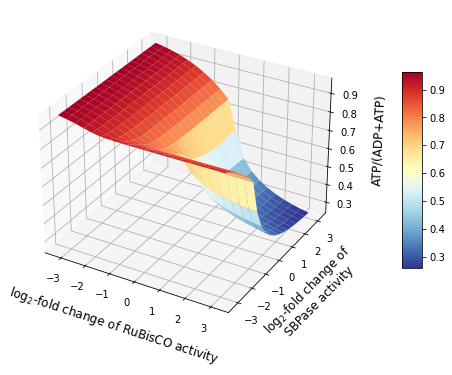

In [293]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')
X,Y=np.meshgrid(xscale,xscale)
(cmin, cmax, vmin, vmax, cavg, vavg) = mdfs1000

disp = get_interpolated_values(cavg,"ATP_norm")

surf=ax.plot_surface(X,Y,disp.reshape(20,20),cmap='RdYlBu_r', edgecolor='none')

ax.set_xlabel("log$_2$-fold change of RuBisCO activity",labelpad=10)
ax.set_ylabel("log$_2$-fold change of\nSBPase activity",labelpad=10)
ax.set_zlabel("ATP/(ADP+ATP)",labelpad=10)

fig.colorbar(surf,shrink=0.6,aspect=10,pad=0.1)


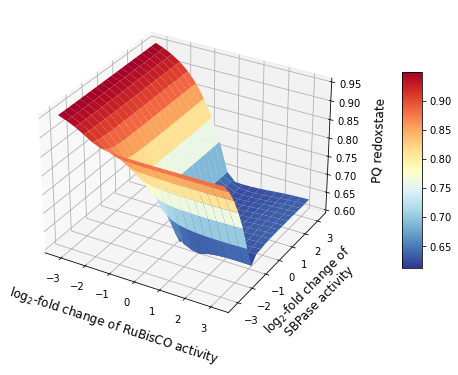

In [295]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')
X,Y=np.meshgrid(xscale,xscale)
(cmin, cmax, vmin, vmax, cavg, vavg) = mdfs1000

disp = get_interpolated_values(cavg,"PQ_redoxstate")

surf=ax.plot_surface(X,Y,disp.reshape(20,20),cmap='RdYlBu_r', edgecolor='none')

ax.set_xlabel("log$_2$-fold change of RuBisCO activity",labelpad=10)
ax.set_ylabel("log$_2$-fold change of\nSBPase activity",labelpad=10)
ax.set_zlabel("PQ redoxstate",labelpad=10)

fig.colorbar(surf,shrink=0.6,aspect=10,pad=0.1)


In [129]:
pfd_vals = np.linspace(40,1500,20)
kcyc_vals = par_orig["kcyc"]*(2**xscale)

In [163]:
m=get_model()
s=Simulator(m)
s.initialise(y0)

mdfs_cyc = par_scan_osc_2d(s,"pfd",pfd_vals,"kcyc",kcyc_vals,y0,T_END=2000)
(cmin, cmax, vmin, vmax, cavg, vavg) = mdfs_cyc

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

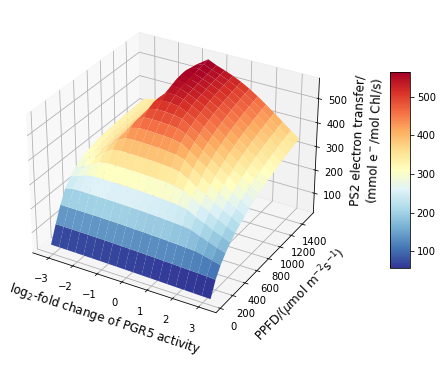

In [277]:
fig = plt.figure(figsize=(10,6))
#ax = plt.axes(projection='3d')
ax = fig.add_subplot(111,projection='3d')

X,Y = np.meshgrid(xscale,pfd_vals)

(cmin, cmax, vmin, vmax, cavg, vavg) = mdfs_cyc
surf = ax.plot_surface(X,Y,2*np.array(vavg.loc["vPS2"]).reshape(20,20),cmap='RdYlBu_r', edgecolor='none')

ax.set_xlabel("log$_2$-fold change of PGR5 activity",labelpad=5)
ax.set_ylabel("PPFD/($\mu$mol m$^{-2}$s$^{-1}$)",labelpad=10)
#ax.set_zlabel("PS2 electron transfer/(mmol e$^-$/mol Chl/s)")
ax.set_zlabel("PS2 electron transfer/\n(mmol e$^-$/mol Chl/s)",labelpad=10)

fig.colorbar(surf,shrink=0.6,aspect=10,ax=ax, pad=0.1)


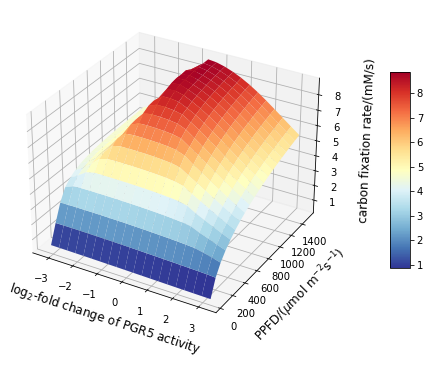

In [298]:
fig = plt.figure(figsize=(10,6))
#ax = plt.axes(projection='3d')
ax = fig.add_subplot(111,projection='3d')

X,Y = np.meshgrid(xscale,pfd_vals)

(cmin, cmax, vmin, vmax, cavg, vavg) = mdfs_cyc
surf = ax.plot_surface(X,Y,2*np.array(vavg.loc["vRuBisCO"]).reshape(20,20),cmap='RdYlBu_r', edgecolor='none')

ax.set_xlabel("log$_2$-fold change of PGR5 activity",labelpad=5)
ax.set_ylabel("PPFD/($\mu$mol m$^{-2}$s$^{-1}$)",labelpad=10)
ax.set_zlabel("carbon fixation rate/(mM/s)",labelpad=10)

fig.colorbar(surf,shrink=0.6,aspect=10,ax=ax, pad=0.1)


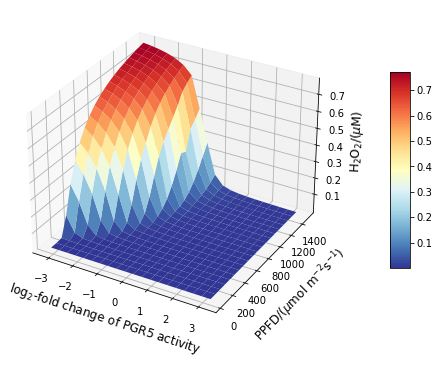

In [279]:
fig = plt.figure(figsize=(10,6))
#ax = plt.axes(projection='3d')
ax = fig.add_subplot(111,projection='3d')

X,Y = np.meshgrid(xscale,pfd_vals)

(cmin, cmax, vmin, vmax, cavg, vavg) = mdfs_cyc
surf = ax.plot_surface(X,Y,1000*np.array(cavg.loc["H2O2"]).reshape(20,20),cmap='RdYlBu_r', edgecolor='none')

ax.set_xlabel("log$_2$-fold change of PGR5 activity",labelpad=5)
ax.set_ylabel("PPFD/($\mu$mol m$^{-2}$s$^{-1}$)",labelpad=10)
ax.set_zlabel("H$_2$O$_2$/($\mu$M)")
#ax.set_zlabel("PS2 electron transfer/\n(mmol e$^-$/mol Chl/s)",labelpad=10)

fig.colorbar(surf,shrink=0.6,aspect=10,ax=ax, pad=0.1)


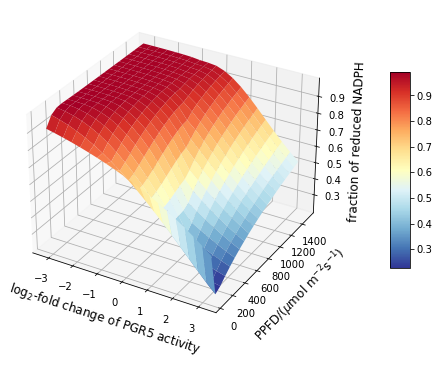

In [297]:
fig = plt.figure(figsize=(10,6))
#ax = plt.axes(projection='3d')
ax = fig.add_subplot(111,projection='3d')

X,Y = np.meshgrid(xscale,pfd_vals)

(cmin, cmax, vmin, vmax, cavg, vavg) = mdfs_cyc
surf = ax.plot_surface(X,Y,np.array(cavg.loc["NADP_redoxstate"]).reshape(20,20),cmap='RdYlBu_r', edgecolor='none')

ax.set_xlabel("log$_2$-fold change of PGR5 activity",labelpad=5)
ax.set_ylabel("PPFD/($\mu$mol m$^{-2}$s$^{-1}$)",labelpad=10)
ax.set_zlabel("fraction of reduced NADPH")
#ax.set_zlabel("PS2 electron transfer/\n(mmol e$^-$/mol Chl/s)",labelpad=10)

fig.colorbar(surf,shrink=0.6,aspect=10,ax=ax, pad=0.1)


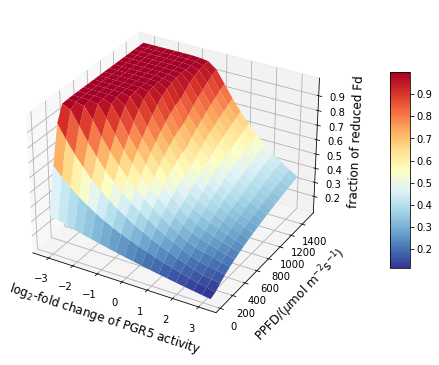

In [299]:
fig = plt.figure(figsize=(10,6))
#ax = plt.axes(projection='3d')
ax = fig.add_subplot(111,projection='3d')

X,Y = np.meshgrid(xscale,pfd_vals)

(cmin, cmax, vmin, vmax, cavg, vavg) = mdfs_cyc
surf = ax.plot_surface(X,Y,np.array(cavg.loc["Fd_redoxstate"]).reshape(20,20),cmap='RdYlBu_r', edgecolor='none')

ax.set_xlabel("log$_2$-fold change of PGR5 activity",labelpad=5)
ax.set_ylabel("PPFD/($\mu$mol m$^{-2}$s$^{-1}$)",labelpad=10)
ax.set_zlabel("fraction of reduced Fd")
#ax.set_zlabel("PS2 electron transfer/\n(mmol e$^-$/mol Chl/s)",labelpad=10)

fig.colorbar(surf,shrink=0.6,aspect=10,ax=ax, pad=0.1)
